# **Setting Current Directory**

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print( os.getcwd())
print(os.listdir('/kaggle/input/'))
print(os.listdir('/kaggle/input/finaldataset/'))
print(os.listdir("/kaggle/input/finaldataset/dataset/Dataset"))
os.chdir('/kaggle/input/finaldataset/dataset/Dataset/')


# Any results you write to the current directory are saved as output.

/kaggle/input/finaldataset/dataset/Dataset
['finaldataset', 'convolutionalneuralnetwork']
['dataset']
['val', 'train', 'test']


**Loading the test, train and validation test**

In [0]:
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2 as cv2
from tqdm import tqdm
import skimage
import scipy
import numpy as np
import imageio
from PIL import Image
from skimage import img_as_ubyte
from skimage import exposure

train_dir ="train/"
test_dir =  "test/"
val_dir =  "val/"


imgcols,imgrows=300,300
 
def get_data(folder):
    """Load the data and labels from the given folder."""
    X = []
    y = []
    count=0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename,cv2.IMREAD_GRAYSCALE)
                #img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (300,300), Image.ANTIALIAS)            
                    img = img_as_ubyte(img_file)

                    # Contrast stretching
                    p2, p98 = np.percentile(img, (2, 98))
                    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

                    # Equalization
                    img_eq = exposure.equalize_hist(img)

                    # Adaptive Equalization
                    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
                    #Try model with and without histogram equalization
                    img_arr = np.asarray(img_adapteq) #with equalization
                    #img_arr=np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

X_test, y_test= get_data(test_dir)
X_train, y_train= get_data(train_dir)
X_val, y_val= get_data(val_dir)


**Reshaping the input data**

In [0]:
# https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

import keras

batch_size = 50

num_classes = 4

epochs = 100    

img_rows, img_cols = 300, 300

y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test,4)
y_val = keras.utils.to_categorical(y_val,4)

X_train = X_train.reshape(2800,img_rows, img_cols ,1)
X_test = X_test.reshape(1200,img_rows, img_cols ,1)
X_val = X_val.reshape(1200,img_rows, img_cols ,1)

print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)
print('y_val shape:', X_val.shape)


print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_val shape:', y_val.shape)

x_train shape: (2800, 300, 300, 1)
x_test shape: (1200, 300, 300, 1)
y_val shape: (1200, 300, 300, 1)
2800 train samples
1200 test samples
y_train shape: (2800, 4)
y_test shape: (1200, 4)
y_val shape: (1200, 4)


**Building the Model**

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.layers import Dense, Dropout, Activation,Flatten, Convolution2D,InputLayer, MaxPooling2D, UpSampling2D
from keras.models import Sequential
import tensorflow as tf

img_cols,img_rows=300,300
num_classes = 4

# Our input feature map is 300x300x1: 300 X 300 for the image pixels, and 1 for grayscale channel
# it can be set to 3 for the three color channels: R, G, and B
#img_input = layers.Input(shape=((img_rows, img_cols, 1)))

input_shape=(img_rows, img_cols,1)
model = Sequential()


input_img = tf.placeholder(dtype=tf.float32, shape=(None, img_rows, img_cols,1))
model.add(InputLayer(input_shape=((img_rows, img_cols,1))))


model.add(Convolution2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=input_shape,
                        name='conv1'
                        ))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Convolution2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=input_shape
                        ))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=input_shape
                        ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=input_shape
                        ))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(filters=128, 
                        kernel_size=(3, 3), 
                        activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Convolution2D(filters=128, 
                        kernel_size=(3, 3), 
                        activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

#Adding dropout to prevent overfitting
#model.add(Dropout(0.25))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300, 300, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 35, 35, 64)        0         
__________

**Setting Optimization, Loss function and metrics**

In [0]:
from tensorflow.keras.optimizers import RMSprop,Adam

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy','mse'])

In [0]:
import matplotlib.pyplot as plt
batch_size = 100
epochs=100
   
history=model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, y_test))


In [0]:
predicts=model.predict(X_test,
              batch_size=1,
              verbose=1)
y_test_non_category = [ np.argmax(t) for t in y_test ]
y_predict = [ np.argmax(t) for t in predicts ]
    # Evaluate on the test data

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1200/1200 [==============================] - 3s 2ms/step
Test loss: 0.6396738374776517
Test accuracy: 0.9091666666666667


dict_keys(['val_loss', 'val_acc', 'val_mean_squared_error', 'loss', 'acc', 'mean_squared_error'])


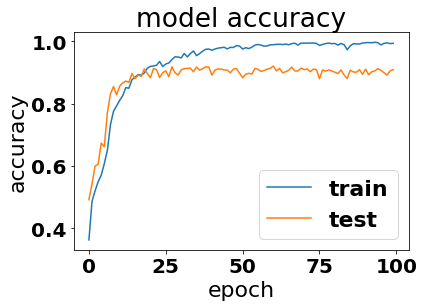

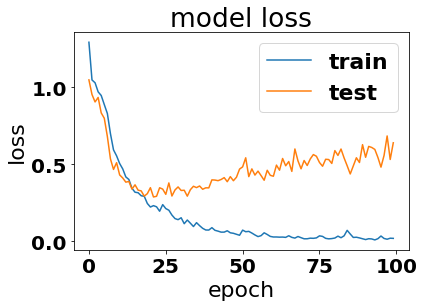

<Figure size 432x288 with 0 Axes>

In [0]:
"""
A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, 
as well as validation loss values and validation metrics values (if applicable).

"""
#structure of history object
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.savefig('/model_accuracy.png')


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('/model_loss.png')

#**Plotting Confusion Matrix**

In [0]:
#https://www.kaggle.com/shrikantds/retina-oct-inception-model
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T) 
    B =(C/C.sum(axis=0))
    labels = ["0-NORMAL","1-CNV","2-DME","3-DRUSEN"]
    
    font = {'family' : 'normal',
    'weight' : 'bold',
    'size' : 22}
    matplotlib.rc('font', **font)
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

**Model Evaluation***

-- Evaluate --
Confusion Matrix
[[289   6   3   2]
 [  2 284   6   8]
 [ 10  11 262  17]
 [ 20  12  12 256]]
-------------------- Confusion matrix --------------------


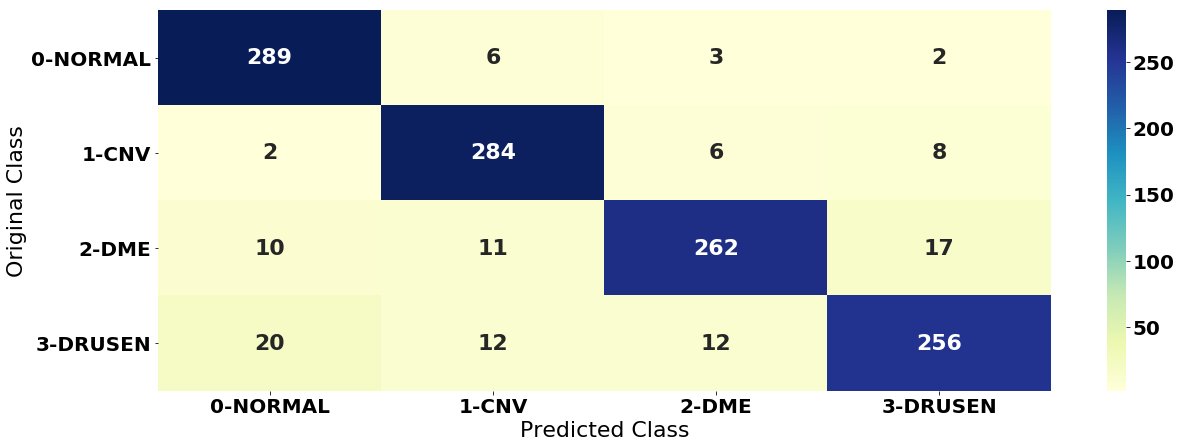

-------------------- Precision matrix (Columm Sum=1) --------------------


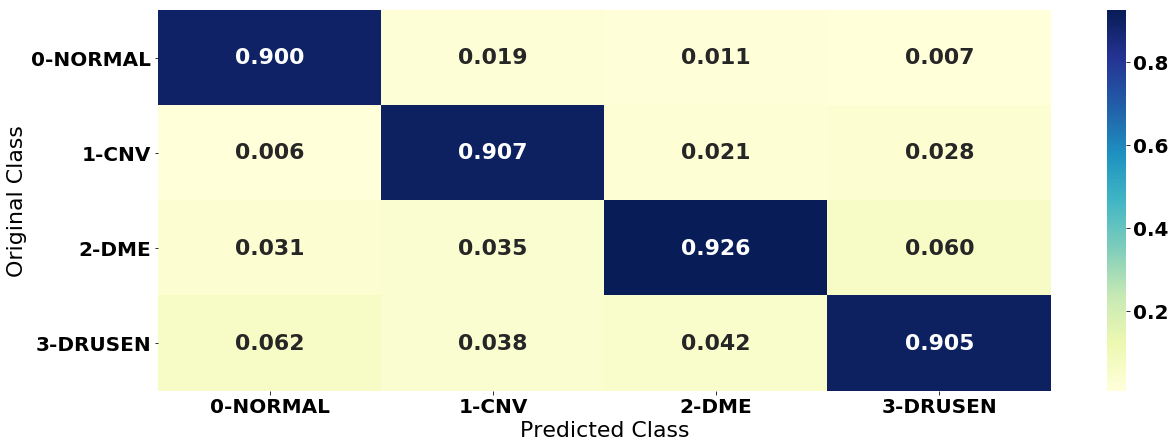

-------------------- Recall matrix (Row sum=1) --------------------


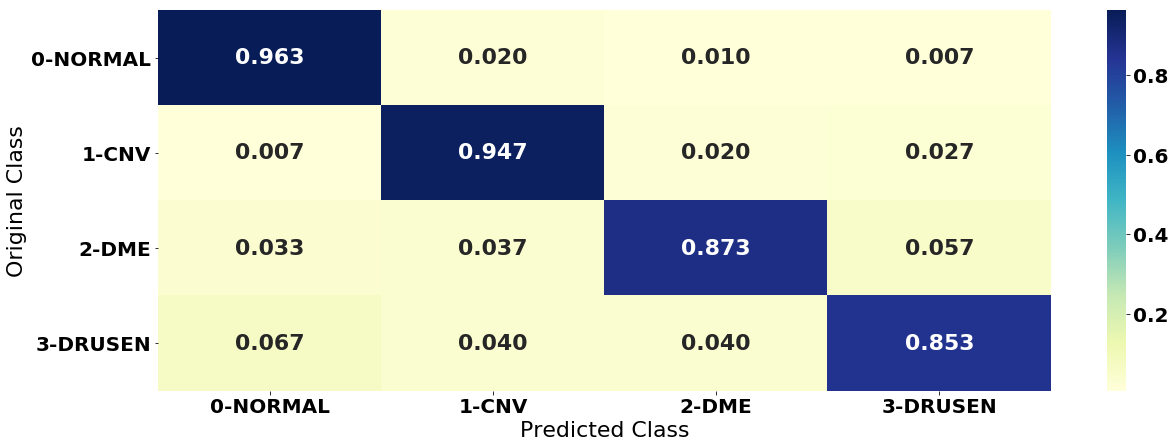

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       300
           1       0.91      0.95      0.93       300
           2       0.93      0.87      0.90       300
           3       0.90      0.85      0.88       300

   micro avg       0.91      0.91      0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200



In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("-- Evaluate --")

print('Confusion Matrix')
cm1 = confusion_matrix(y_test_non_category, y_predict)
print(cm1)
plot_confusion_matrix(y_test_non_category, y_predict)

print('Classification Report')
target_names = ['0', '1','2','3']
print(classification_report(y_test_non_category,y_predict, target_names=target_names))
